In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['font.family']      = 'Arial'

In [2]:
# SUBFUNCTIONS

def merge_capacity_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_capacities
        capacities = capacities.append(df,ignore_index=True)
    return capacities


def get_relative_capacities(results_dict):
    capacities = merge_capacity_data(results_dict)
    # get bas and delta dfs
    bas   = capacities.loc[capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    delta = capacities.loc[~capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    # group
    bas   = bas.groupby(by=['scenario','technology','territory']).max().reset_index()
    delta = delta.groupby(by=['scenario','technology','territory']).max().reset_index()
    # map baseline capacities
    bas = bas.set_index('node')['value'].to_dict()
    delta['bas_cap'] = delta.node.map(bas)
    # compute delta
    delta['relative_change'] = delta['value'] - delta['bas_cap']
    return delta


def merge_cost_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    costs = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_costs
        costs = costs.append(df,ignore_index=True)
    return costs


def export_results_for_chord(merged_results,scenario):
    '''Export a csv for chord plots
    '''
    df = merged_results[scenario].results_edge_flows.copy()

    df['from_territory'] = ''
    df['to_territory'] = ''
    df = df[df.from_id.str.contains('generation')].reset_index(drop=True)

    df.loc[df.from_id.str.contains('israel'),'from_territory'] = 'ISR'
    df.loc[df.from_id.str.contains('west_bank'),'from_territory'] = 'WBK'
    df.loc[df.from_id.str.contains('gaza'),'from_territory'] = 'GZA'
    df.loc[df.from_id.str.contains('jordan'),'from_territory'] = 'JOR'
    df.loc[df.from_id.str.contains('egypt'),'from_territory'] = 'EGY'

    df.loc[df.to_id.str.contains('israel'),'to_territory'] = 'ISR'
    df.loc[df.to_id.str.contains('west_bank'),'to_territory'] = 'WBK'
    df.loc[df.to_id.str.contains('gaza'),'to_territory'] = 'GZA'
    df.loc[df.to_id.str.contains('jordan'),'to_territory'] = 'JOR'
    df.loc[df.to_id.str.contains('egypt'),'to_territory'] = 'EGY'
    
    df = df[['from_territory','to_territory','value']]
    df = df.groupby(by=['from_territory','to_territory']).sum().reset_index()
    
    # units?
    df.value = df.value.divide(10**3)
    # save
    df.to_csv('plots/chord_data/' + scenario + '.csv',index=False)
    print('done.')
    
    
def map_territory(df,on):
    '''Map territory onto dataframe
    '''
    # add regions
    df['territory'] = np.nan
    df.loc[df[on].str.contains('jordan'),'territory']  = 'Jordan'
    df.loc[df[on].str.contains('israel'),'territory']  = 'Israel'
    df.loc[df[on].str.contains('west'),'territory']    = 'West Bank'
    df.loc[df[on].str.contains('gaza'),'territory']    = 'Gaza'
    df.loc[df[on].str.contains('super'),'territory']   = 'Shortage'
    df.loc[df[on].str.contains('egypt'),'territory']   = 'Egypt'
    return df


def map_technology(df,on):
    '''Map technology onto dataframe
    '''
    df['technology'] = np.nan
    df.loc[df.from_id.str.contains('solar'),'technology']       = 'Solar'
    df.loc[df.from_id.str.contains('coal'),'technology']        = 'Coal'
    df.loc[df.from_id.str.contains('diesel'),'technology']      = 'Diesel'
    df.loc[df.from_id.str.contains('ccgt'),'technology']        = 'Gas'
    df.loc[df.from_id.str.contains('gas'),'technology']         = 'Gas'
    df.loc[df.from_id.str.contains('shale'),'technology']       = 'Shale'
    df.loc[df.from_id.str.contains('wind'),'technology']        = 'Wind'
    df.loc[df.from_id.str.contains('storage'),'technology']     = 'Storage'
    df.loc[df.from_id.str.contains('super'),'technology']       = 'Shortage'
    return df


def map_sox_emissions(df,on):
    df['sox'] = df[on] * df['technology'].map(sox)
    return df


def map_nox_emissions(df,on):
    df['nox'] = df[on] * df['technology'].map(nox)
    return df


def map_co2_emissions(df,on):
    df['co2'] = df[on] * df['technology'].map(co2)
    return df

def map_water_use(df,on):
    df['water_use'] = df[on] * df['technology'].map(water_use)
    return df

## Load scenario results

In [3]:
file = open('../outputs/results/model_run_results.pkl','rb')
results = pickle.load(file)
file.close()

In [4]:
# export_results_for_chord(results,scenario='BAU')
# export_results_for_chord(results,scenario='NCO')
# export_results_for_chord(results,scenario='EAG')
# export_results_for_chord(results,scenario='COO')
# export_results_for_chord(results,scenario='UTO')

## Plot: summary of scenario analysis

This figure shows: 

    a. Total cost ($) by scenario
    b. Total capacity (GW) by scenario and technology
    c. Summary of various variables by scenario (e.g., NOx, SOx etc.)

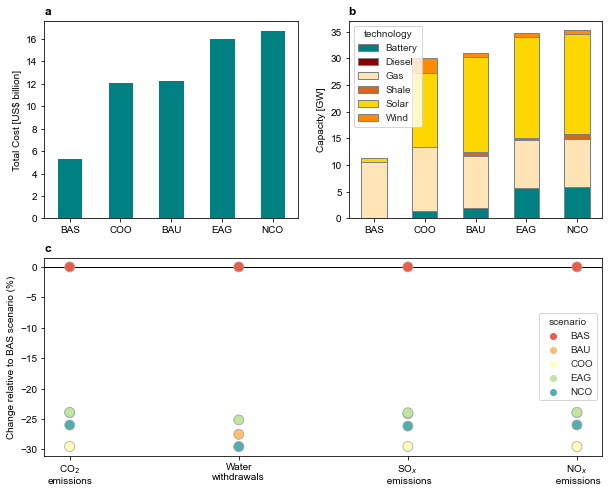

In [5]:
merged_flows = pd.DataFrame()
for k in results.keys():
    sn = get_source_nodes(results[k].nodes).name.to_list()
    df = results[k].results_edge_flows.loc[results[k].results_edge_flows.from_id.isin(sn)]
    df = df.drop(['to_id','commodity','timestep','hour'],axis=1)
    df = df.groupby(by=['from_id','day','month','year','scenario']).sum().reset_index()
    df = map_territory(df,on='from_id')
    df = map_technology(df,on='from_id')
    merged_flows = merged_flows.append(df,ignore_index=True)

merged_flows = map_sox_emissions(merged_flows,on='value')
merged_flows = map_nox_emissions(merged_flows,on='value')
merged_flows = map_co2_emissions(merged_flows,on='value')
merged_flows = map_water_use(merged_flows,on='value')

merged_flows = merged_flows.groupby(by=['month','year','scenario']).sum().reset_index()

# adjust units
merged_flows['co2'] = merged_flows['co2'].divide(10**6)
merged_flows['nox'] = merged_flows['nox'].divide(10**6)
merged_flows['sox'] = merged_flows['sox'].divide(10**6)

monthly_means = merged_flows.groupby(by=['year','scenario']).mean().reset_index()
monthly_means = monthly_means[['scenario','sox','nox','co2','water_use']]

# append capacities
capacities = merge_capacity_data(results)
#capacities = capacities.groupby(by=['technology','scenario']).max().reset_index()
capacities = capacities.pivot_table(index=['scenario'],
                                    columns=['technology'],
                                    values='value',
                                    aggfunc='sum')

battery = capacities['Battery'].to_dict()
monthly_means['battery'] = monthly_means.scenario.map(battery)

def normalise_column(df,columns):
    df = monthly_means.copy()
    for i in columns:
        column=i
        baseline_value = df.loc[df.scenario=='BAS',column].values[0]
        df[column] = ((df[column]-baseline_value)/baseline_value)*100
    return df

monthly_means = normalise_column(monthly_means,columns=['nox','co2','sox','water_use'])
#monthly_means = monthly_means[monthly_means.scenario != 'BAS'].reset_index(drop=True)

hls_colours = sns.color_palette("Spectral", as_cmap=True)

costs = merge_cost_data(results)
#costs = costs.groupby(by=['technology','scenario']).sum().reset_index()
costs = costs.pivot_table(index=['scenario'],
                          columns=['technology'],
                          values='totex',
                          aggfunc='sum')

costs['total'] = costs.sum(axis=1)
costs = costs.reset_index(drop=False)
costs = costs[['scenario','total']]
costs = costs.sort_values('total')
costs['total'] = costs['total'].divide(10**9)
# run function
capacities = merge_capacity_data(results)
# groupby to get max values
# capacities = capacities.groupby(by=['technology','scenario']).max().reset_index()
# pivot for bar chart
capacities = capacities.pivot_table(index=['scenario'],
                                    columns=['technology'],
                                    values='value',
                                    aggfunc='max')
# sort by ascending
capacities['total'] = capacities.sum(axis=1)
capacities = capacities.sort_values("total").drop('total',axis=1)
capacities = capacities.drop(['Coal','Gas Reservoir'],axis=1)


f = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)

sns.set_style("ticks")
costs.set_index('scenario').plot.bar(ax=ax1,color='teal',rot=0,legend=False)
ax1.set_xlabel('')
ax1.set_ylabel('Total Cost [US$ billion]')
#ax1.set_ylim([-30*0.03,30])
ax1.set_title('a',fontweight='bold',loc='left')

capacities.divide(1000).plot.bar(stacked=True,rot=0,ax=ax2,
                                 color=[technology_color_dict.get(x, '#333333') for x in capacities.columns],
                                 edgecolor='gray')

ax2.set_xlabel('')
ax2.set_ylabel('Capacity [GW]')
ax2.set_title('b',fontweight='bold',loc='left')
#ax2.set_ylim([-40*0.03,40])

monthly_means = monthly_means.melt(id_vars='scenario',value_vars=['co2','water_use','sox','nox',])
plt.axhline(y=0,linestyle='-',color='black',linewidth=1,zorder=1)
sns.scatterplot(x='variable',y='value',hue='scenario',ax=ax3,
                data=monthly_means,s=100,palette='Spectral',edgecolor='darkgray')

ax3.set_xlabel('')
ax3.set_ylabel('Change relative to BAS scenario (%)')
ax3.set_title('c',fontweight='bold',loc='left')
#ax3.set_ylim([-35,10])
ax3.set_xticklabels(['CO$_2$\nemissions','Water\nwithdrawals','SO$_x$\n emissions','NO$_x$\n emissions'])

f.savefig('../outputs/figures/scenario_analysis.pdf',bbox_inches='tight')

In [6]:
costs = merge_cost_data(results)

costs

,node,capacity_change,technology,territory,capex,opex,totex,scenario
0,israel_wind,0.000000,Wind,Israel,0.000000e+00,0.000000e+00,0.000000e+00,BAS
1,israel_solar,0.000000,Solar,Israel,0.000000e+00,0.000000e+00,0.000000e+00,BAS
2,israel_natural_gas,6488.202079,Gas,Israel,3.088384e+09,6.488202e+08,3.737204e+09,BAS
3,israel_diesel,0.000000,Diesel,Israel,0.000000e+00,0.000000e+00,0.000000e+00,BAS
4,israel_coal,0.000000,Coal,Israel,0.000000e+00,0.000000e+00,0.000000e+00,BAS
...,...,...,...,...,...,...,...,...
130,israel_gas_storage,0.000000,Gas Reservoir,Israel,NaN,NaN,NaN,COO
131,israel_battery_storage,1391.073407,Battery,Israel,1.313897e+09,2.086610e+07,1.334763e+09,COO
132,jordan_battery_storage,757.611515,Battery,Jordan,7.155792e+08,1.136417e+07,7.269434e+08,COO
133,west_bank_battery_storage,164.106121,Battery,West Bank,1.550015e+08,2.461592e+06,1.574631e+08,COO


## Plot: capacities by scenario for each region

This figure shows the capacity of each technology implemented under each scenario.

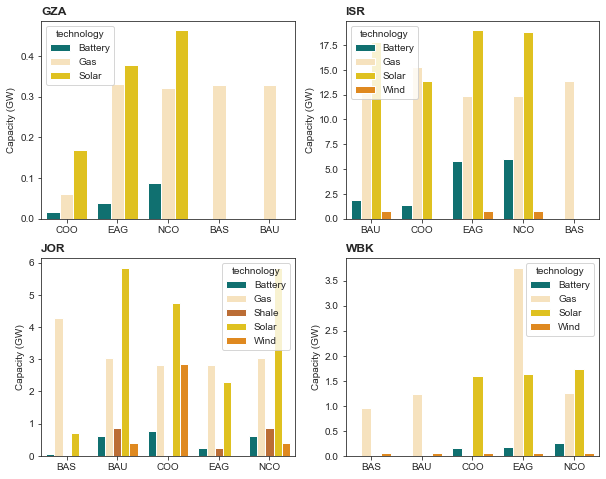

In [7]:
caps = merge_capacity_data(results)
caps = caps.groupby(by=['node','scenario']).max().reset_index()
caps = caps.loc[caps.value>0].reset_index(drop=True)
caps.value = caps.value.divide(1000)

titles = {'Israel':'ISR','Jordan':'JOR','West Bank':'WBK','Gaza':'GZA',}
ylims = [ [-0.3*0.04,0.4],[-20*0.03,200],[-14*0.03,14],[-1.2*0.03,1.2] ]

f,axs = plt.subplots(2,2, figsize=(10,8))
ax = axs.ravel()
for i in range(len(caps.territory.unique())):
    idx_caps = caps.loc[caps.territory == caps.territory.unique()[i]].reset_index(drop=True)
    idx_caps = idx_caps.sort_values(by='scenario')
    idx_caps = idx_caps.groupby(by=['technology','scenario']).sum().reset_index()
    sns.barplot(x='scenario',y='value',hue='technology',
                data=idx_caps,ax=ax[i],errwidth=0,
                palette=technology_color_dict)
    
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Capacity (GW)')
    ax[i].set_title(titles[caps.territory.unique()[i]],loc='left',fontweight='bold')
    #ax[i].set_ylim(ylims[i])
    
f.savefig('../outputs/figures/supp_capacity_by_scenario.pdf',bbox_inches='tight')

(1.0, 48.0)

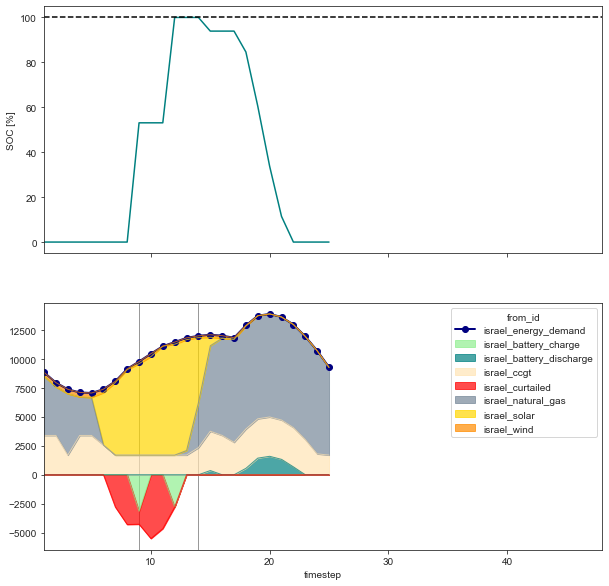

In [8]:
scenario = 'NCO'
region = 'israel'
node = region + '_battery_storage'
month=1

f,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True)

results[scenario].plot_battery_storage_volume(node=node,days=2,month=month,ax=ax[0])
results[scenario].plot_supply_curve(region=region,days=2,month=month,ax=ax[1],shade_battery_charge=True)

ax[1].set_xlim([1,48])
#plt.xticks(np.arange(0, 26, 2.0))

In [9]:
# import plotly.io as pio
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# pio.renderers.default = 'iframe'

# results['COO'].plot_flows_sankey()

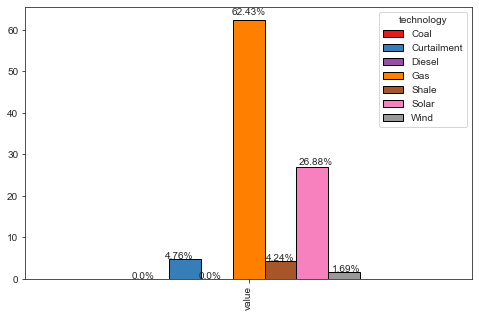

In [10]:
results['NCO'].plot_total_supply(cmap='Set1')

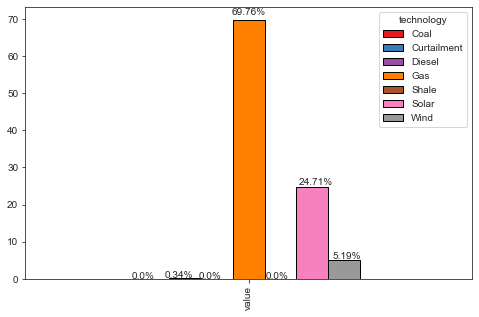

In [11]:
results['COO'].plot_total_supply(cmap='Set1')

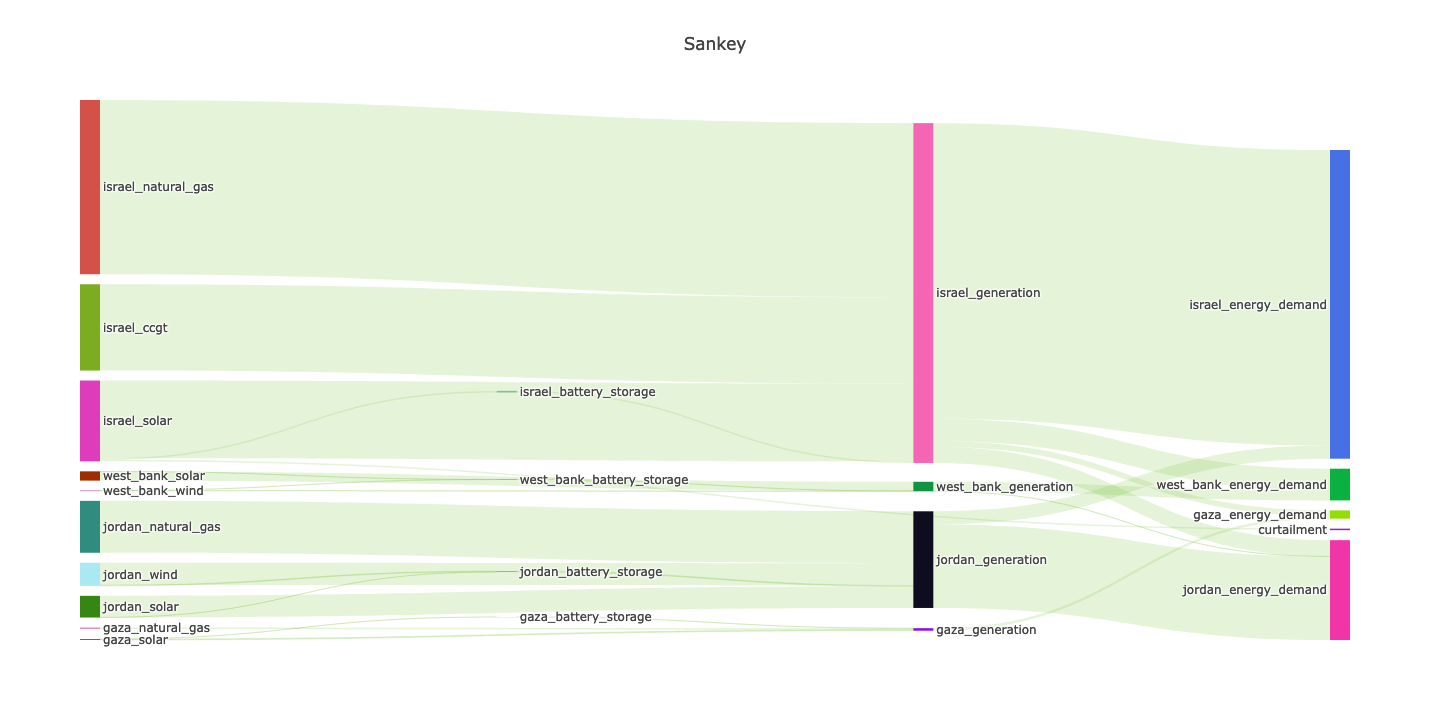

In [12]:
results['COO'].plot_flows_sankey()

In [13]:
results['COO'].results_costs.sort_values(by='totex')

,node,capacity_change,technology,territory,capex,opex,totex,scenario
0,israel_wind,0.000000,Wind,Israel,0.000000e+00,0.000000e+00,0.000000e+00,COO
19,jordan_shale,0.000000,Shale,Jordan,0.000000e+00,0.000000e+00,0.000000e+00,COO
18,gaza_diesel,0.000000,Diesel,Gaza,0.000000e+00,0.000000e+00,0.000000e+00,COO
3,israel_diesel,0.000000,Diesel,Israel,0.000000e+00,0.000000e+00,0.000000e+00,COO
4,israel_coal,0.000000,Coal,Israel,0.000000e+00,0.000000e+00,0.000000e+00,COO
5,israel_ccgt,0.000000,Gas,Israel,0.000000e+00,0.000000e+00,0.000000e+00,COO
17,west_bank_diesel,0.000000,Diesel,West Bank,0.000000e+00,0.000000e+00,0.000000e+00,COO
16,west_bank_natural_gas,0.000000,Gas,West Bank,0.000000e+00,0.000000e+00,0.000000e+00,COO
8,jordan_natural_gas,0.000000,Gas,Jordan,0.000000e+00,0.000000e+00,0.000000e+00,COO
9,jordan_diesel,0.000000,Diesel,Jordan,0.000000e+00,0.000000e+00,0.000000e+00,COO


In [14]:
results['COO'].results_costs['totex'].sum() / results['BAU'].results_costs['totex'].sum()

0.9877113998490568

In [15]:
results['COO'].results_costs['totex'].divide(10**9).sum()

12.189244674357248

In [16]:
results['BAU'].results_costs['totex'].divide(10**9).sum()

12.34089702338155

In [19]:
results['BAU'].edges

,commodity,minimum,maximum,cost,plot,capex,from_id,to_id,from_type,to_type,from_subty,to_subtype,geometry,timestep
0,electricity,0.0,1.000000e+08,5,0.0,0.0,jordan_solar,jordan_battery_storage,source,storage,solar,battery,"LINESTRING (35.65969 29.58792, 35.68092 29.556...",1
1,electricity,0.0,1.000000e+08,100,0.0,0.0,jordan_natural_gas,jordan_generation,source,junction,natural gas,junction,"LINESTRING (36.13624 29.73706, 35.73049 29.76475)",1
2,electricity,0.0,1.000000e+08,100,0.0,0.0,jordan_diesel,jordan_generation,source,junction,diesel,junction,"LINESTRING (36.13624 29.59170, 35.73049 29.76475)",1
3,electricity,0.0,1.000000e+08,135,0.0,0.0,jordan_coal,jordan_generation,source,junction,coal,junction,"LINESTRING (36.01099 29.50665, 35.73049 29.76475)",1
4,electricity,0.0,1.000000e+08,1000000,0.0,0.0,jordan_ccgt,jordan_generation,source,junction,ccgt,junction,"LINESTRING (36.04573 29.85827, 35.73049 29.76475)",1
5,electricity,0.0,1.000000e+08,10,0.0,0.0,jordan_wind,jordan_battery_storage,source,storage,wind,battery,"LINESTRING (35.77904 29.52703, 35.74010 29.527...",1
6,electricity,0.0,1.000000e+08,5,0.0,0.0,israel_solar,israel_battery_storage,source,storage,solar,battery,"LINESTRING (34.90528 30.57511, 34.90541 30.56937)",1
7,electricity,0.0,1.000000e+08,135,0.0,0.0,israel_coal,israel_generation,source,junction,coal,junction,"LINESTRING (34.81368 30.57774, 34.85292 30.58484)",1
8,electricity,0.0,1.000000e+08,1000000,0.0,0.0,israel_ccgt,israel_generation,source,junction,ccgt,junction,"LINESTRING (34.88552 30.55529, 34.85292 30.58484)",1
9,electricity,0.0,1.000000e+08,100,0.0,0.0,israel_gas_storage,israel_generation,storage,junction,gas reservoir,junction,"LINESTRING (34.85275 30.55342, 34.85292 30.58484)",1


In [18]:
results['BAU'].nodes

,name,type,subtype,commodity,capacity,uom,function,nodal_flow,territory,plot,status,capex,geometry
0,israel_energy_demand,sink,demand,electricity,NaN,None,None,True,Israel,1,online,1000000,POINT (35.11892 30.78331)
1,west_bank_energy_demand,sink,demand,electricity,NaN,None,None,True,West Bank,1,online,1000000,POINT (35.26035 32.03843)
2,gaza_energy_demand,sink,demand,electricity,NaN,None,None,True,Gaza,1,online,1000000,POINT (34.36369 31.40915)
3,jordan_generation,junction,junction,electricity,NaN,None,None,False,Jordan,1,online,1000000,POINT (35.73049 29.76475)
4,israel_generation,junction,junction,electricity,NaN,None,None,False,Israel,1,online,1000000,POINT (34.85292 30.58484)
5,israel_wind,source,wind,electricity,125.0,MW,None,False,Israel,0,online,980,POINT (34.89779 30.56635)
6,israel_solar,source,solar,electricity,3000.0,MW,None,False,Israel,0,online,310,POINT (34.90528 30.57511)
7,israel_natural_gas,source,natural gas,electricity,4024.0,MW,peak,False,Israel,0,online,700,POINT (34.85284 30.51637)
8,israel_diesel,source,diesel,electricity,700.0,MW,None,False,Israel,0,online,1175,POINT (34.82154 30.56154)
9,israel_coal,source,coal,electricity,4800.0,MW,None,False,Israel,0,online,1200,POINT (34.81368 30.57774)
